# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import warnings
warnings.filterwarnings('ignore')
tf.random.set_seed(42)

2025-04-20 14:52:31.809971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745160752.044810      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745160752.107498      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Preprocessing

In [2]:
def normalize(img):
    img = tf.cast(img, dtype=tf.float32) / 127.5 - 1.0  # Normalize images to [-1,1]
    return img

def denormalize(img):
        return (img + 1) / 2

In [3]:
train_colored_path = "/kaggle/input/unified/bukonohero/colored" # path of dataset
BATCH_SIZE = 32 # batch size
IMG_SIZE = (128, 128)  # (height, width)


# Load training 
train_colored_dataset = tf.keras.utils.image_dataset_from_directory(
    train_colored_path,
    image_size=IMG_SIZE,
    subset = "training",
    validation_split = 0.01,
    batch_size=BATCH_SIZE,
    labels = None,
    shuffle=False,
).map(normalize, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).cache()# normalize data set in graph mode call_AUTOTUNE_to prevent bottlenecks in memory
test_colored_dataset = tf.keras.utils.image_dataset_from_directory(
    train_colored_path,
    image_size=IMG_SIZE,
    subset = "validation",
    validation_split = 0.01,
    batch_size=BATCH_SIZE,
    labels = None,
    shuffle=False,
).map(normalize, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).cache()# normalize data set in graph mode call_AUTOTUNE_to prevent bottlenecks in memory
#cache Data to ram to reduce the overhead of fetching data from cpu

Found 1050 files.
Using 1040 files for training.


I0000 00:00:1745160768.454243      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745160768.455044      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 1050 files.
Using 10 files for validation.


In [4]:
train_gray_path = "/kaggle/input/unified/bukonohero/grayscale" # path of dataset
BATCH_SIZE = 32 # batch size
IMG_SIZE = (128, 128)  # (height, width)

# Load training 
train_gray_dataset = image_dataset_from_directory(
    train_gray_path,
    image_size=IMG_SIZE,
    subset = "training",
    validation_split = 0.01,
    batch_size=BATCH_SIZE,
    shuffle=False,
    labels = None,
).map(normalize, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).cache()# normalize data set in graph mode call_AUTOTUNE_to prevent bottlenecks in memory
test_gray_dataset = image_dataset_from_directory(
    train_gray_path,
    image_size=IMG_SIZE,
    subset = "validation",
    validation_split = 0.01,
    batch_size=BATCH_SIZE,
    shuffle=False,
    labels = None,
).map(normalize, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).cache()# normalize data set in graph mode call_AUTOTUNE_to prevent bottlenecks in memory
#cache Data to ram to reduce the overhead of fetching data from cpu

Found 1094 files.
Using 1084 files for training.
Found 1094 files.
Using 10 files for validation.


In [5]:
train_gray_path = "/kaggle/input/unified/bukonohero/grayscale" 
train_color_path = "/kaggle/input/unified/bukonohero/colored"  # Add your color images path here
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

def augment_image(image):
    # If dealing with batched data
    if len(tf.shape(image)) == 4:
        # Apply augmentations separately to each image in batch
        return tf.map_fn(augment_single_image, image)
    else:
        # If we have a single image, just augment it
        return augment_single_image(image)

# Function to augment a single image
def augment_single_image(image):
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
    
    # Random rotation
    angle = tf.random.uniform((), minval=-0.2, maxval=0.2)
    image = tf.image.rot90(image, k=tf.cast(angle * 2, tf.int32))
    
    # Random zoom (crop and resize)
    zoom_factor = tf.random.uniform((), minval=0.8, maxval=1.0)
    h, w = tf.shape(image)[0], tf.shape(image)[1]
    crop_size_h = tf.cast(tf.cast(h, tf.float32) * zoom_factor, tf.int32)
    crop_size_w = tf.cast(tf.cast(w, tf.float32) * zoom_factor, tf.int32)
    
    # Make sure crop sizes are valid (not larger than image dimensions)
    crop_size_h = tf.minimum(crop_size_h, h)
    crop_size_w = tf.minimum(crop_size_w, w)
    
    # Random crop and resize
    image = tf.image.random_crop(image, [crop_size_h, crop_size_w, 3])
    image = tf.image.resize(image, [h, w])
    
    # Random contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    return image

# Apply normalization and augmentation to color images
def process_color_image(images):
    # Normalize first
    normalized = normalize(images)
    # Then augment
    augmented = augment_image(normalized)
    return augmented

# Load grayscale dataset
train_gray_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_gray_path,
    image_size=IMG_SIZE,
    subset="training",
    validation_split=0.01,
    batch_size=BATCH_SIZE,
    shuffle=False,
    labels=None,
    seed=42
).map(normalize, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).cache()

test_gray_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_gray_path,
    image_size=IMG_SIZE,
    subset="validation",
    validation_split=0.01,
    batch_size=BATCH_SIZE,
    shuffle=False,
    labels=None,
    seed=42
).map(normalize, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).cache()

# Load color dataset with augmentation
train_colored_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_color_path,
    image_size=IMG_SIZE,
    subset="training",
    validation_split=0.01,
    batch_size=BATCH_SIZE,
    shuffle=False,
    labels=None,
    seed=42
).map(process_color_image, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).cache()

test_colored_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_color_path,
    image_size=IMG_SIZE,
    subset="validation",
    validation_split=0.01,
    batch_size=BATCH_SIZE,
    shuffle=False,
    labels=None,
    seed=42
).map(normalize, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).cache()

# Print dataset sizes
print(f"Gray training images: {tf.data.experimental.cardinality(train_gray_dataset).numpy() * BATCH_SIZE}")
print(f"Color training images: {tf.data.experimental.cardinality(train_colored_dataset).numpy() * BATCH_SIZE}")

# Calculate how many additional augmented batches we need
gray_batches = tf.data.experimental.cardinality(train_gray_dataset).numpy()
color_batches = tf.data.experimental.cardinality(train_colored_dataset).numpy()
additional_batches_needed = max(0, gray_batches - color_batches)

# If we need more color images, create additional augmented versions with stronger augmentation
if additional_batches_needed > 0:
    # Function for additional augmentation with different parameters
    def extra_augment(image):
        # Use stronger augmentation parameters
        if tf.random.uniform(()) > 0.3:  # More frequent flipping
            image = tf.image.flip_left_right(image)
        
        # Random brightness adjustment
        image = tf.image.random_brightness(image, max_delta=0.3)
        
        # More aggressive contrast
        image = tf.image.random_contrast(image, lower=0.6, upper=1.4)
        
        # Random saturation (if applicable)
        image = tf.image.random_saturation(image, lower=0.6, upper=1.4)
        
        return image
    
    # Take some batches and apply extra augmentation
    additional_dataset = train_colored_dataset.take(additional_batches_needed)
    additional_dataset = additional_dataset.map(extra_augment, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Combine original and augmented datasets
    train_colored_dataset = train_colored_dataset.concatenate(additional_dataset)
    
    print(f"Color training images (after additional augmentation): {tf.data.experimental.cardinality(train_colored_dataset).numpy() * BATCH_SIZE}")

Found 1094 files.
Using 1084 files for training.
Found 1094 files.
Using 10 files for validation.
Found 1050 files.
Using 1040 files for training.
Found 1050 files.
Using 10 files for validation.
Gray training images: 1088
Color training images: 1056
Color training images (after additional augmentation): 1088


Colored training batch size: 32
Colored testing batch size: 10
Gray training batch size: 32
Gray testing batch size: 10
Using minimum batch size: 10
Selected random index: 7


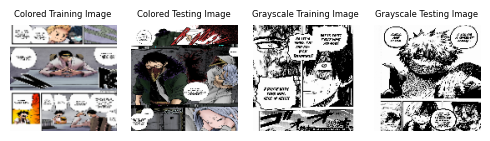

In [6]:
train_colored_dataset_iter, test_colored_dataset_iter = iter(train_colored_dataset), iter(test_colored_dataset)
train_gray_dataset_iter, test_gray_dataset_iter = iter(train_gray_dataset), iter(test_gray_dataset)
batch_train_colored_dataset, batch_test_colored_dataset = next(train_colored_dataset_iter), next(test_colored_dataset_iter)
batch_train_gray_dataset, batch_test_gray_dataset = next(train_gray_dataset_iter), next(test_gray_dataset_iter)

# Get the minimum batch size to ensure we don't go out of bounds
min_batch_size = min(
    batch_train_colored_dataset.shape[0],
    batch_test_colored_dataset.shape[0],
    batch_train_gray_dataset.shape[0],
    batch_test_gray_dataset.shape[0]
)

# Print batch sizes to help diagnose the issue
print(f"Colored training batch size: {batch_train_colored_dataset.shape[0]}")
print(f"Colored testing batch size: {batch_test_colored_dataset.shape[0]}")
print(f"Gray training batch size: {batch_train_gray_dataset.shape[0]}")
print(f"Gray testing batch size: {batch_test_gray_dataset.shape[0]}")
print(f"Using minimum batch size: {min_batch_size}")

# Select a random index that's within bounds for all datasets
random_idx = np.random.randint(0, min_batch_size)
print(f"Selected random index: {random_idx}")

# Create figure with subplots
fig, axes = plt.subplots(1, 4, figsize=(5, 2))

# Display colored training image
axes[0].imshow(denormalize(batch_train_colored_dataset[random_idx]))
axes[0].set_title("Colored Training Image",fontsize=6)
axes[0].axis('off')

# Display colored testing image
axes[1].imshow(denormalize(batch_test_colored_dataset[random_idx]))
axes[1].set_title("Colored Testing Image",fontsize=6)
axes[1].axis('off')

# Display grayscale training image
gray_train_img = batch_train_gray_dataset[random_idx].numpy()
if len(gray_train_img.shape) > 2 and gray_train_img.shape[-1] == 1:
    gray_train_img = np.squeeze(gray_train_img, axis=-1)
axes[2].imshow(gray_train_img, cmap='gray')
axes[2].set_title("Grayscale Training Image",fontsize=6)
axes[2].axis('off')

# Display grayscale testing image
gray_test_img = batch_test_gray_dataset[random_idx].numpy()
if len(gray_test_img.shape) > 2 and gray_test_img.shape[-1] == 1:
    gray_test_img = np.squeeze(gray_test_img, axis=-1)
axes[3].imshow(gray_test_img, cmap='gray')
axes[3].set_title("Grayscale Testing Image",fontsize=6)
axes[3].axis('off')

plt.tight_layout()
plt.show()

In [7]:
def conv2d(inputs, filters, kernel_size=4, strides=2, activation=None, inst_norm=False):
    # Apply the conv layer to inputs
    x = tf.keras.layers.SpectralNormalization(tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding='same'))(inputs)
    
    # Instance normalization (using GroupNormalization)
    if inst_norm:
        x = tf.keras.layers.GroupNormalization(groups=filters, axis=-1)(x)
    
    # LeakyReLU activation
    if activation == 'leakyrelu':
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    return x  # Return the tensor output

def deconv2d(inputs, skip_input, filters, kernel_size=4, strides=2, inst_norm=False):
    # Apply the transposed conv to inputs
    x = tf.keras.layers.Conv2DTranspose(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding='same',
        activation='relu')(inputs)
    
    if inst_norm:
        x = tf.keras.layers.GroupNormalization(groups=filters, axis=-1)(x)
    
    x = tf.keras.layers.Concatenate()([x, skip_input])
    
    return x



In [8]:
def Generator(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Encoder path
    e1 = conv2d(inputs, 32, kernel_size=4, strides=2, activation='leakyrelu', inst_norm=True)  # 32x32
    e2 = conv2d(e1, 64, kernel_size=4, strides=2, activation='leakyrelu', inst_norm=True)      # 16x16
    e3 = conv2d(e2, 128, kernel_size=4, strides=2, activation='leakyrelu', inst_norm=True)      # 8x8
    e4 = conv2d(e3, 256, kernel_size=4, strides=2, activation='leakyrelu', inst_norm=True)     # 4x4
    e5 = conv2d(e4, 512, kernel_size=4, strides=2, activation='leakyrelu', inst_norm=True)
    e6 = conv2d(e5, 1024, kernel_size=4, strides=2, activation='leakyrelu', inst_norm=True)# 2x2
    
    # Decoder path with skip connections
    d5 = deconv2d(e6, e5, 512, kernel_size=4, strides=2, inst_norm=True)
    d4 = deconv2d(d5, e4, 256, kernel_size=4, strides=2, inst_norm=True)  # 4x4
    d3 = deconv2d(d4, e3, 128, kernel_size=4, strides=2, inst_norm=True)           # 8x8
    d2 = deconv2d(d3, e2, 64, kernel_size=4, strides=2, inst_norm=True)           # 16x16
    d1 = deconv2d(d2, e1, 32, kernel_size=4, strides=2, inst_norm=True)           # 32x32
    
    # Final upsampling to original size
    output_img = tf.keras.layers.Conv2DTranspose(filters=input_shape[2],kernel_size=4,strides=2,padding='same',activation='tanh')(d1)
    
    model = tf.keras.models.Model(inputs, output_img)
    return model

In [9]:
def build_discriminator(input_shape,name=None):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = conv2d(inputs,64,kernel_size=4,strides=2,activation='leakyrelu',inst_norm=True)
    x = conv2d(x,128,kernel_size=4,strides=2,activation='leakyrelu',inst_norm=True)
    x = conv2d(x,256,kernel_size=4,strides=2,activation='leakyrelu',inst_norm=True)
    x = conv2d(x,512,kernel_size=4,strides=2,activation='leakyrelu',inst_norm=True)
    x = conv2d(x,1024,kernel_size=4,strides=2,activation='leakyrelu',inst_norm=True)
    out = tf.keras.layers.Conv2D(3, kernel_size=1, strides=1, padding='same')(x)
    discriminator = tf.keras.models.Model(inputs, out, name=name)
    return discriminator


In [10]:
class cycle_gan(tf.keras.Model):
  def __init__(self, generator_t, generator_s, discriminator_t, discriminator_s):
        super().__init__()
        self.generator_t = generator_t
        self.generator_s = generator_s
        self.discriminator_t = discriminator_t
        self.discriminator_s = discriminator_s
  def compile(self, g_t_optimizer, g_s_optimizer, d_t_optimizer, d_s_optimizer, loss_fn):
        super().compile()  # This works in Python 3+
        # Fixed variable names to match parameter names
        self.g_t_optimizer = g_t_optimizer
        self.g_s_optimizer = g_s_optimizer
        self.d_t_optimizer = d_t_optimizer
        self.d_s_optimizer = d_s_optimizer
        self.loss_fn = loss_fn


  @tf.function
  def train_step(self,data):
      real_x,real_y = data
      # ✅ One GradientTape for Discriminators
      with tf.GradientTape(persistent=True) as tape_d:
          fake_y = self.generator_t(real_x, training=True)
          fake_x = self.generator_s(real_y, training=True)

          disc_real_x = self.discriminator_s(real_x, training=True)
          disc_fake_x = self.discriminator_s(fake_x, training=True)
          disc_real_y = self.discriminator_t(real_y, training=True)
          disc_fake_y = self.discriminator_t(fake_y, training=True)

          # Compute discriminator losses
          disc_t_loss = loss_fn(tf.ones_like(disc_real_y), disc_real_y) + \
                        loss_fn(tf.zeros_like(disc_fake_y), disc_fake_y)
          disc_s_loss = loss_fn(tf.ones_like(disc_real_x), disc_real_x) + \
                        loss_fn(tf.zeros_like(disc_fake_x), disc_fake_x)

      # Apply gradients for both discriminators
      grads_dt = tape_d.gradient(disc_t_loss, self.discriminator_t.trainable_variables)
      grads_ds = tape_d.gradient(disc_s_loss, self.discriminator_s.trainable_variables)
      self.d_t_optimizer.apply_gradients(zip(grads_dt, self.discriminator_t.trainable_variables))
      self.d_s_optimizer.apply_gradients(zip(grads_ds,self.discriminator_s.trainable_variables))
      del tape_d  # ✅ Free memory

      # ✅ One GradientTape for Generators
      with tf.GradientTape(persistent=True) as tape_g:
          fake_y = self.generator_t(real_x, training=True)
          fake_x = self.generator_s(real_y, training=True)

          cycled_x = self.generator_s(fake_y, training=True)
          cycled_y = self.generator_t(fake_x, training=True)

          same_x = self.generator_s(real_x, training=True)
          same_y = self.generator_t(real_y, training=True)

          disc_fake_y = self.discriminator_t(fake_y, training=False)#previous True
          disc_fake_x = self.discriminator_s(fake_x, training=False)#previous True

          # Compute generator losses
          g_target_loss = loss_fn(tf.ones_like(disc_fake_y), disc_fake_y)
          g_source_loss = loss_fn(tf.ones_like(disc_fake_x), disc_fake_x)

          cycle_loss_t = tf.reduce_mean(tf.abs(real_y - cycled_y)) * 10
          cycle_loss_s = tf.reduce_mean(tf.abs(real_x - cycled_x)) * 10

          id_loss_t = tf.reduce_mean(tf.abs(real_y - same_y)) * 10 * 0.5
          id_loss_s = tf.reduce_mean(tf.abs(real_x - same_x)) * 10 * 0.5

          # Total loss
          total_loss_t = g_target_loss + cycle_loss_t + id_loss_t
          total_loss_s = g_source_loss + cycle_loss_s + id_loss_s

      # Apply gradients for both generators
      grads_gt = tape_g.gradient(total_loss_t, self.generator_t.trainable_variables)
      grads_gs = tape_g.gradient(total_loss_s, self.generator_s.trainable_variables)
      self.g_t_optimizer.apply_gradients(zip(grads_gt, self.generator_t.trainable_variables))
      self.g_s_optimizer.apply_gradients(zip(grads_gs, self.generator_s.trainable_variables))
      del tape_g  # ✅ Free memory

      return {
          "dict_t":disc_t_loss,
          "disc_s":disc_s_loss,
          "gen_t":total_loss_t,
          "gen_s":total_loss_s,
      }


In [11]:
class VisualizationCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, g_t, g_s, num_samples=4, denormalize_func=None, frequency=5):
        """
        Callback to visualize domain transformations during training
        
        Args:
            val_dataset: Validation dataset containing samples from both domains
            g_AB: Generator model for Domain A (grayscale) to Domain B (colored)
            g_BA: Generator model for Domain B (colored) to Domain A (grayscale)
            num_samples: Number of samples to visualize from each domain
            denormalize_func: Function to denormalize images if normalized
            frequency: Frequency of epochs to visualize results
        """
        super(VisualizationCallback, self).__init__()
        self.val_dataset = val_dataset
        self.g_t = g_t  # Grayscale to Colored generator
        self.g_s = g_s  # Colored to Grayscale generator
        self.num_samples = num_samples
        self.denormalize = denormalize_func if denormalize_func else lambda x: x
        self.frequency = frequency
        
        # Get samples from the validation dataset
        for batch in val_dataset.take(1):
            if isinstance(batch, tuple) and len(batch) == 2:
                self.domain_A, self.domain_B = batch  # domain_A: grayscale, domain_B: colored
            else:
                self.domain_A, self.domain_B = batch['A'], batch['B']
            
            # Take only the first num_samples
            self.domain_A = self.domain_A[:num_samples]
            self.domain_B = self.domain_B[:num_samples]
            break
    
    def on_epoch_end(self, epoch, logs=None):
        """Visualize transformations at the end of specified epochs"""
        if (epoch + 1) % self.frequency == 0:
            # Create a figure to plot the transformations
            plt.figure(figsize=(16, 4 * self.num_samples))
            
            # Plot for Domain A (grayscale) to Domain B (colored)
            for i in range(self.num_samples):
                # Original grayscale image
                plt.subplot(self.num_samples, 4, i * 4 + 1)
                plt.title(f'Original (Grayscale)')
                plt.imshow(self.denormalize(self.domain_A[i]), cmap='gray')
                plt.axis('off')
                
                # Generated colored image
                fake_B = self.g_t(self.domain_A[i:i+1])
                plt.subplot(self.num_samples, 4, i * 4 + 2)
                plt.title(f'Generated (Colored)')
                plt.imshow(self.denormalize(fake_B[0]))
                plt.axis('off')
                
                # Original colored image
                plt.subplot(self.num_samples, 4, i * 4 + 3)
                plt.title(f'Original (Colored)')
                plt.imshow(self.denormalize(self.domain_B[i]))
                plt.axis('off')
                
                # Generated grayscale image
                fake_A = self.g_s(self.domain_B[i:i+1])
                plt.subplot(self.num_samples, 4, i * 4 + 4)
                plt.title(f'Generated (Grayscale)')
                plt.imshow(self.denormalize(fake_A[0]), cmap='gray')
                plt.axis('off')
            
            plt.suptitle(f'Domain Transformations - Epoch {epoch+1}', fontsize=16)
            plt.tight_layout()
            plt.savefig(f'Transformations_Epoch_{epoch+1}.png')
            plt.close()

In [12]:
g_t = Generator((128,128,3))
g_s = Generator((128,128,3))
d_t = build_discriminator((128,128,3))
d_s = build_discriminator((128,128,3))
cycle_gan = cycle_gan(g_t,g_s,d_t,d_s)
#Generator_c_to_g.summary()
#Discriminator_c_to_g.summary()
#Discriminator_g_to_c.summary()
#Discriminator_g_to_c.summary()

In [13]:
optimizer_dt = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.5, beta_2=0.999)  # Lower LR for D # 1e-4
optimizer_ds = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.5, beta_2=0.999) # 1e-4
optimizer_gt = tf.keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.5, beta_2=0.999)  # Keep G at 2e-4
optimizer_gs = tf.keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.5, beta_2=0.999)
loss_fn = tf.keras.losses.BinaryCrossentropy()
cycle_gan.compile(optimizer_gt,optimizer_gs,optimizer_dt,optimizer_ds,loss_fn)

In [14]:
val_dataset = tf.data.Dataset.zip((test_gray_dataset,test_colored_dataset))
combined_dataset = tf.data.Dataset.zip((train_gray_dataset, train_colored_dataset))

In [17]:
visualization_cb = VisualizationCallback(val_dataset,g_t,g_s,5,denormalize,100)  # Visualize every 5 epochs



In [ ]:
cycle_gan.fit(combined_dataset,epochs=1000,callbacks=[visualization_cb])

Epoch 1/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 523ms/step - dict_t: 15.2217 - disc_s: 15.1988 - gen_s: 11.9438 - gen_t: 14.0219
Epoch 2/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 532ms/step - dict_t: 15.3167 - disc_s: 15.2019 - gen_s: 11.9243 - gen_t: 13.9120
Epoch 3/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 541ms/step - dict_t: 15.2833 - disc_s: 15.1620 - gen_s: 11.8489 - gen_t: 14.0103
Epoch 4/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 548ms/step - dict_t: 15.3108 - disc_s: 15.2009 - gen_s: 11.8233 - gen_t: 14.0836
Epoch 5/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 559ms/step - dict_t: 15.3002 - disc_s: 15.2002 - gen_s: 11.7913 - gen_t: 13.9400
Epoch 6/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 565ms/step - dict_t: 15.2903 - disc_s: 15.1863 - gen_s: 11.7878 - gen_t: 13.8636
Epoch 7/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 576ms/step - dict_t: 15.3128 - disc_s: 15.1778 - gen_s: 11.7543 - gen_t: 13.8174
Epoch 8/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 582ms/step - dict_t: 15.3106 - disc_s: 15.1847 - gen_s: 11.7343 - gen_t: 13.7870
